## Exercise Set 2 for OSM 

### Dynamic Programming with John Stachurski

Exercises for the [OSM](https://bfi.uchicago.edu/osm) bootcamp dynamic programming section.

We will use the following libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

### Exercise 1

Consider the setting of the [stochastic optimal growth model](https://lectures.quantecon.org/py/optgrowth.html), with the same notation and same assumptions on the primitives $u$, $f$, $\beta$ and $\phi$. 

Let $\mathscr C$ be all continuous bounded functions on $\mathbb R_+$.

Let $\sigma \in \Sigma$ be any feasible policy and let $U$ be the operator from $\mathscr C$ to itself defined by

$$ Uw(y) = u(\sigma(y)) + \beta \int w(f(y - \sigma(y))z) \phi(dz) \qquad (y \in \mathbb R_+)$$

Prove that $U$ is a contraction mapping with respect to the supremum distance.  Argue that the unique fixed point of $U$ in $\mathscr C$ is $v_\sigma$.

("Argue" means provide a sketch of a proof that contains the key ideas, plus some intuition.  Or give a complete, formal proof, if you can.)

### Solution

Pick $y \in \mathbb{R}_{+}$. Pick $w, w^{\prime} \in \mathscr{C}$ Then:
\begin{align*}
\lvert Uw(y) - Uw^{\prime}(y) \rvert &= \left\lvert \left(u(\sigma(y)) + \beta \int w(f(y - \sigma(y))z) \phi(dz)\right) - \left(u(\sigma(y)) + \beta \int w^{\prime}(f(y - \sigma(y))z) \phi(dz)\right) \right\rvert \\
&= \left\lvert \ \beta \int w(f(y - \sigma(y))z) - w^{\prime}(f(y - \sigma(y))z) \phi(dz) \ \right\rvert \\
&\leq \beta \int \left\lvert \ w(f(y - \sigma(y))z) - w^{\prime}(f(y - \sigma(y))z) \ \right\rvert \phi(dz) \\
&\leq \beta \int \left\| \ w - w^{\prime} \ \right\|_{sup} \ \phi(dz) \\
&= \beta \ \left\| \ w - w^{\prime} \ \right\|_{sup} \int \phi(dz) \\
&= \beta \ \left\| \ w - w^{\prime} \ \right\|_{sup} \\
\end{align*}
Consider the set $S := \{\lvert Uw(y) - Uw^{\prime}(y) \rvert : y \in \mathbb{R}_{+}\}$. Note that $\sup S = \| Uw - Uw^{\prime} \|_{sup}$. Also, note that $\beta\|w - w^{\prime}\|_{sup}$ is an upperbound for $S$, as shown above. Thus, by the defintion of $\sup$, we have that:
$$ \| \ Uw - Uw^{\prime} \ \|_{sup} \leq \beta \ \left\| \ w - w^{\prime} \ \right\|_{sup}$$
Thus, since $\beta \in (0, 1)$ and $U : \mathscr{C} \rightarrow \mathscr{C}$, we have that $U$ is a contraction mapping with respect to the supremum distance.

We know that $\mathscr{C}$ is complete, so we can apply the Banach Fixed Point Theorem and assert that $\exists$ a unique fixed point $w^{*} \in \mathscr{C}$ s.t. $Uw^{*} = w^{*}$.

The intuition for why $w^{*} = v_{\sigma}$ is the following. Assume that the agent uses the policy function $\sigma$ every period. Then, we can think of $v_{\sigma}$ as the agent's expected lifetime utility. So, in each period, the agent's expected lifetime utility (from that period onward) should be given by $v_{\sigma}(y_t)$, where $y_t$ is how much output the agent has in that period. In particular, the agent's expected lifetime utility from tomorrow onward should be given by $v_{\sigma}(y_{t+1})$, if today is period $t$. Thus, the agent's expected lifetime utility from today onwards is their utility today plus the discounted expected value of $v_{\sigma}(y_{t+1})$ (I say expected value because $y_{t+1}$ depends on a stochastic shock). This is precisely our expression for the fixed point of U:

$$ v_{\sigma}(y_t) = u(\sigma(y_t)) + \beta \ \mathbb{E}[v_{\sigma}(y_{t + 1})] $$

Or equivalently:

$$ v_{\sigma}(y) = u(\sigma(y)) + \beta \int v_{\sigma}(f(y - \sigma(y))z) \phi(dz) $$


### Exercise 2

Notation and concepts continue from exercise 2.

Use the fact you proved in exercise 2, combined with piecewise linear interpolation method we used for the Bellman operator, to compute and plot good approximations of the value $v_\sigma$ of the policies

* $\sigma_1(y) = 0.95 y$
* $\sigma_2(y) = H(y) y$ where $H$ is the cdf of the lognormal $LN(0, 0.5)$ distribution.

For the latter use `scipy.stats.lognorm.cdf(y, 0.5)`

For the primitives, use the default specification in the `LogLinearOG` class from the [stochastic optimal growth model lecture](https://lectures.quantecon.org/py/optgrowth.html).

Plot your results, choosing grid and plotting dimensions to best illustrate the two functions.  Based on the plot alone, argue that neither of these policies is an optimal policy.

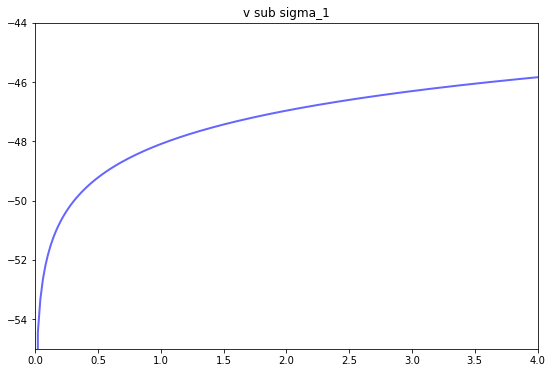

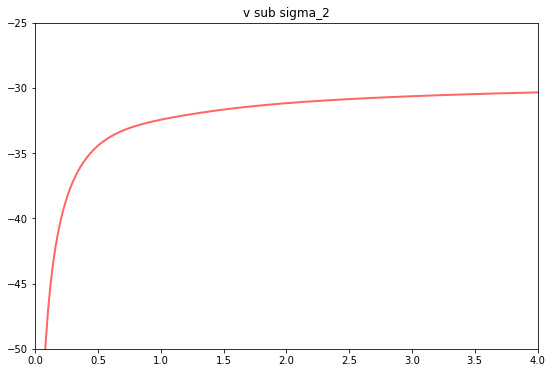

In [2]:
import scipy.stats as stats

class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)


def get_next_w(w, grid, beta, u, f, sigma, shocks, Tw=None):
    """
    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        Tw[i] = u(sigma(y)) + beta * np.mean(w_func(f(y - sigma(y)) * shocks))
    
    return Tw

lg = LogLinearOG()
# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

w = 5 * np.log(grid)  # An initial condition
fig1, ax1 = plt.subplots(figsize=(9, 6))
ax1.set_title("v sub sigma_1")
ax1.set_ylim(-55, -44)
ax1.set_xlim(np.min(grid), np.max(grid))
for i in range(200):
    w = get_next_w(w,
                   grid,
                   beta,
                   np.log,
                   lambda k: k**alpha,
                   lambda y: 0.95 * y,
                   shocks)

ax1.plot(grid, w, 'b', lw=2, alpha=0.6)

plt.show()

w = 5 * np.log(grid)  # An initial condition
fig2, ax2 = plt.subplots(figsize=(9, 6))
ax2.set_title("v sub sigma_2")
ax2.set_ylim(-50, -25)
ax2.set_xlim(np.min(grid), np.max(grid))
for i in range(200):
    w = get_next_w(w,
                   grid,
                   beta,
                   np.log,
                   lambda k: k**alpha,
                   lambda y: stats.lognorm.cdf(y, 0.5),
                   shocks)

ax2.plot(grid, w, 'r', lw=2, alpha=0.6)

plt.show()

We know that the true value function is higher than both of the policy value functions $v_{\sigma_1}$ and $v_{\sigma_2}$ that we have found. This indicates that neither policy maximizes expected lifetime utility, and that both policies are therefore suboptimal.